In [2]:
pip install tensorflow keras matplotlib


Note: you may need to restart the kernel to use updated packages.


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


Data Generators

In [13]:
# Parameters
img_height, img_width = 64, 64  # Adjust based on your dataset
batch_size = 32

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

# Validation and Test Data (No Augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    'dataset/validation',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)


Found 27600 images belonging to 47 classes.
Found 9100 images belonging to 47 classes.
Found 9103 images belonging to 47 classes.


Building the CNN Model

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(47, activation='softmax')  # 49 classes for Kannada alphabets
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


E:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 47)                  │          12,079 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,285,231 (4.90 MB)

 Trainable params: 1,285,231 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

Training the Model

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
checkpoint = ModelCheckpoint('best_cnn_model.keras', monitor='val_accuracy', save_best_only=True)
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

# Training
# Training
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr, checkpoint]
)



Epoch 1/50
862/862 ━━━━━━━━━━━━━━━━━━━━ 72s 83ms/step - accuracy: 0.5784 - loss: 1.4655 - val_accuracy: 0.6871 - val_loss: 1.0753 - learning_rate: 0.0010
Epoch 2/50
862/862 ━━━━━━━━━━━━━━━━━━━━ 0s 37us/step - accuracy: 0.7188 - loss: 0.9954 - val_accuracy: 0.5833 - val_loss: 1.2634 - learning_rate: 0.0010
Epoch 3/50
862/862 ━━━━━━━━━━━━━━━━━━━━ 71s 81ms/step - accuracy: 0.6091 - loss: 1.3379 - val_accuracy: 0.6824 - val_loss: 1.0861 - learning_rate: 0.0010
Epoch 4/50
862/862 ━━━━━━━━━━━━━━━━━━━━ 0s 29us/step - accuracy: 0.5000 - loss: 1.7868 - val_accuracy: 0.5833 - val_loss: 1.0925 - learning_rate: 0.0010
Epoch 5/50
862/862 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.6292 - loss: 1.2821 - val_accuracy: 0.6996 - val_loss: 1.0244 - learning_rate: 0.0010
Epoch 6/50
862/862 ━━━━━━━━━━━━━━━━━━━━ 0s 30us/step - accuracy: 0.5938 - loss: 1.8033 - val_accuracy: 0.5833 - val_loss: 1.2125 - learning_rate: 0.0010
Epoch 7/50
862/862 ━━━━━━━━━━━━━━━━━━━━ 70s 80ms/step - accuracy: 0.6346 - loss

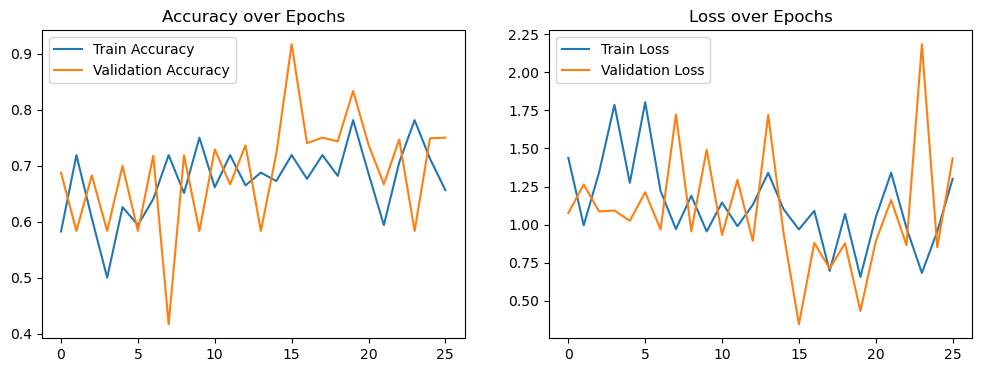

In [11]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()


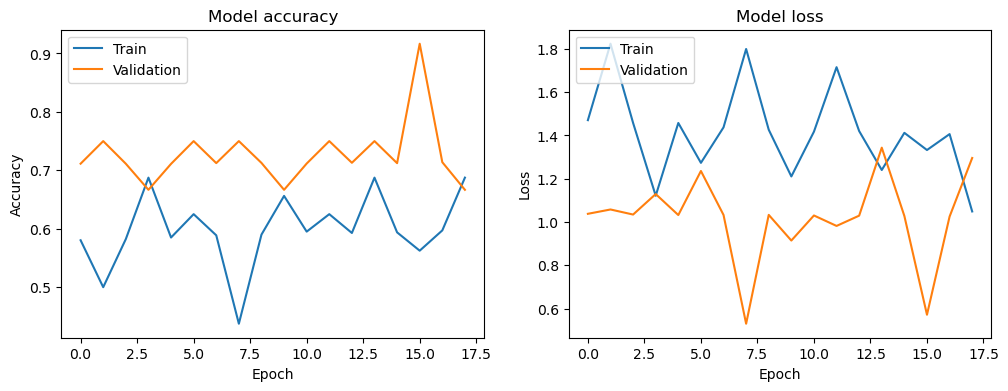

In [24]:
import matplotlib.pyplot as plt

# Assuming history is your fit result
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [12]:
from tensorflow.keras.models import load_model

best_model = load_model('best_cnn_model.keras')


In [13]:
# Load the best model
model.load_weights('best_cnn_model.keras')

# Evaluate on Test Data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Accuracy: {test_acc * 100:.2f}%')


284/284 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.7904 - loss: 0.6867
Test Accuracy: 75.58%


285/285 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
Classification Report:
              precision    recall  f1-score   support

           ಅ       0.77      0.74      0.75       203
           ಆ       0.69      0.79      0.74       200
           ಇ       0.83      0.81      0.82       200
           ಈ       0.96      0.94      0.95       200
           ಉ       0.89      0.94      0.91       200
           ಊ       0.95      0.95      0.95       200
           ಋ       0.84      0.90      0.87       200
           ಎ       0.73      0.74      0.73       200
           ಏ       0.81      0.69      0.74       200
           ಐ       0.65      0.85      0.74       200
           ಒ       0.82      0.64      0.72       200
           ಓ       0.90      0.80      0.85       200
           ಔ       0.91      0.91      0.91       200
           ಕ       0.62      0.77      0.69       200
           ಖ       0.84      0.87      0.86       200
           ಗ       0.87      0.83      0.85       200
           ಘ    

E:\Anaconda\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 3205 (\N{KANNADA LETTER A}) missing from current font.
  fig.canvas.draw()
E:\Anaconda\Lib\site-packages\seaborn\utils.py:61: UserWarning: Matplotlib currently does not support Kannada natively.
  fig.canvas.draw()
E:\Anaconda\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 3206 (\N{KANNADA LETTER AA}) missing from current font.
  fig.canvas.draw()
E:\Anaconda\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 3207 (\N{KANNADA LETTER I}) missing from current font.
  fig.canvas.draw()
E:\Anaconda\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 3208 (\N{KANNADA LETTER II}) missing from current font.
  fig.canvas.draw()
E:\Anaconda\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 3209 (\N{KANNADA LETTER U}) missing from current font.
  fig.canvas.draw()
E:\Anaconda\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 3210 (\N{KANNADA LETTER UU}) missing from current font.
  fig.c

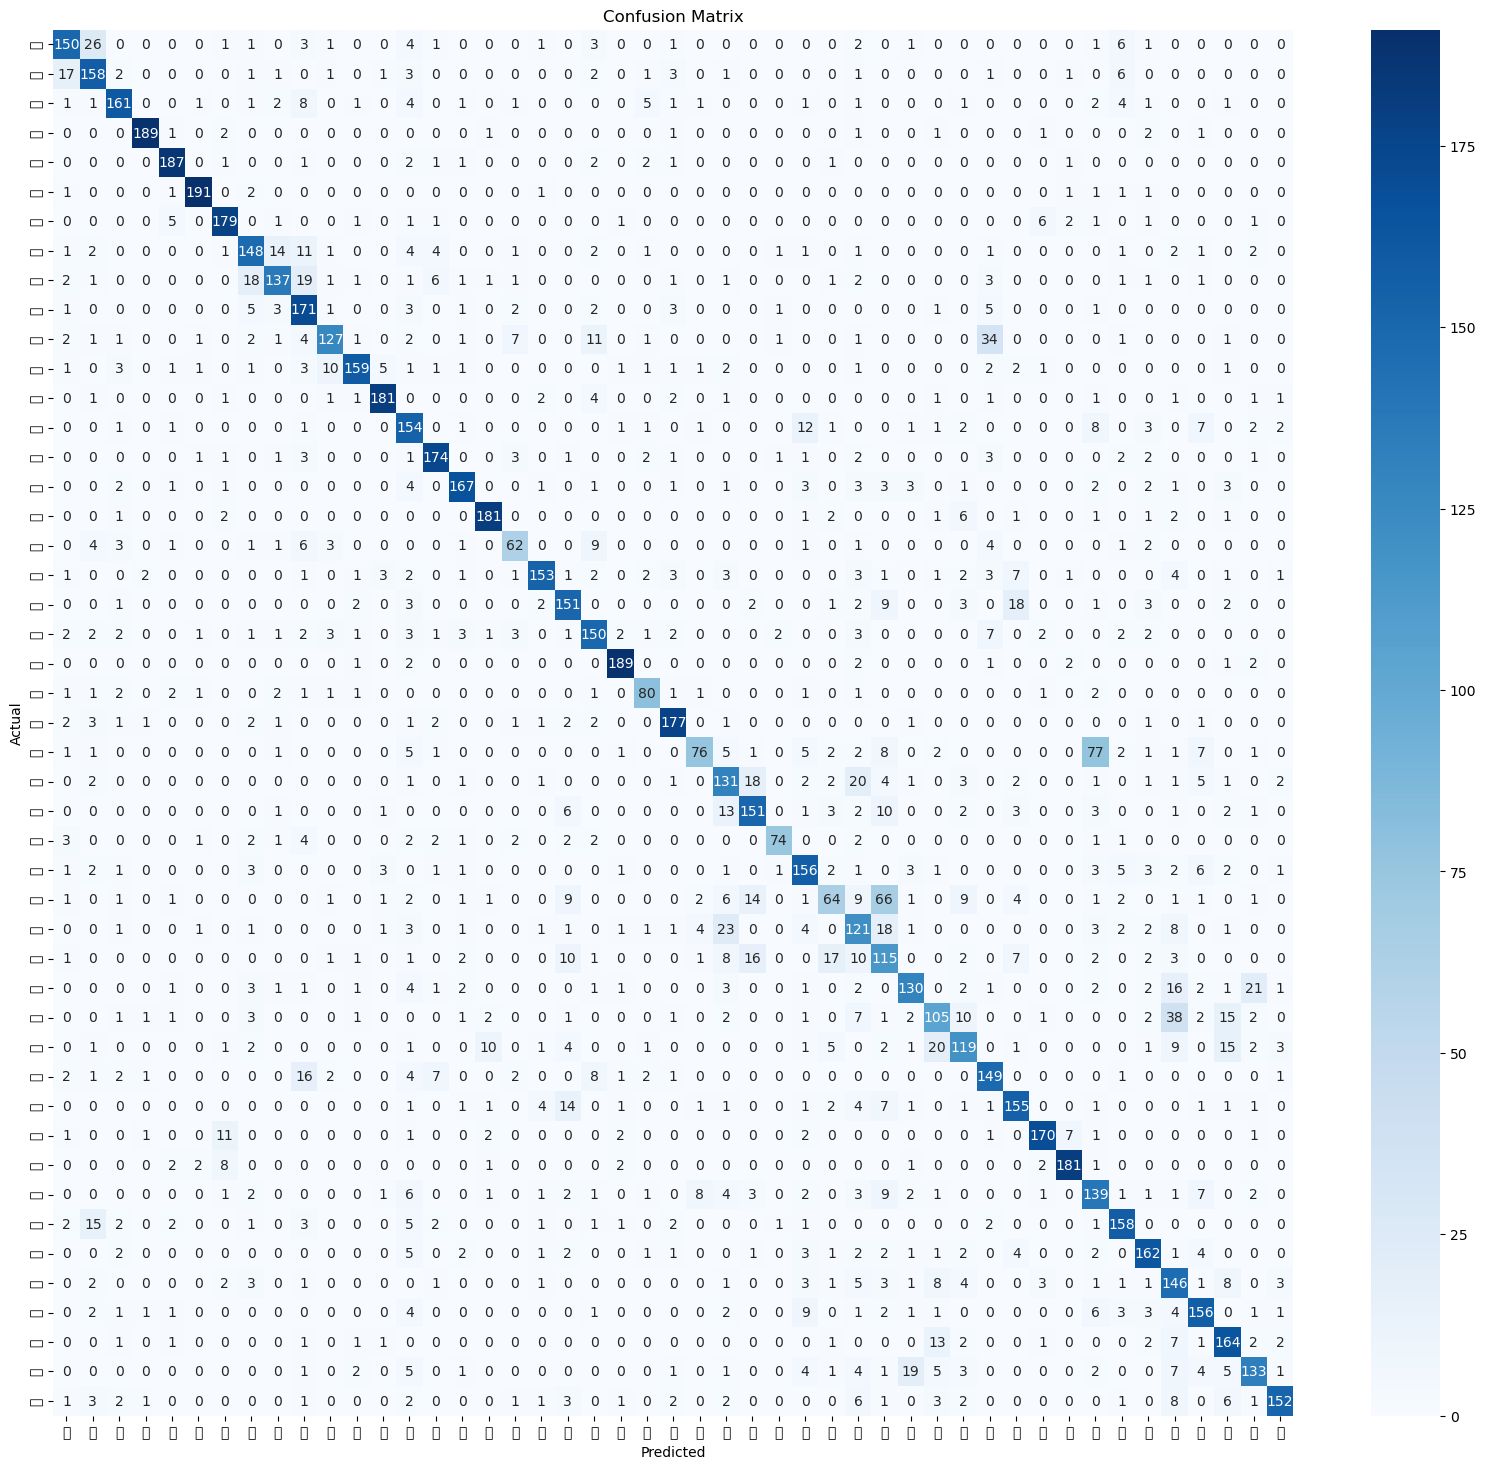

In [14]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure test_generator has shuffle=False
test_generator.reset()

# Predict probabilities for all test images
# Convert steps to int to avoid TypeError
steps = int(np.ceil(test_generator.samples / batch_size))
predictions = model.predict(test_generator, steps=steps)

# Convert probabilities to class indices
y_pred = np.argmax(predictions, axis=1)

# True labels
y_true = test_generator.classes

# Mapping from class indices to class labels
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(20, 18))  # Adjust size based on number of classes
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


Model Tuning

In [40]:
pip install keras-tuner


  Obtaining dependency information for keras-tuner from https://files.pythonhosted.org/packages/db/5d/945296512980b0827e93418514c8be9236baa6f0a1e8ca8be3a2026665b0/keras_tuner-1.4.7-py3-none-any.whl.metadata
  Obtaining dependency information for kt-legacy from https://files.pythonhosted.org/packages/16/53/aca9f36da2516db008017db85a1f3cafaee0efc5fc7a25d94c909651792f/kt_legacy-1.0.5-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   ------------ -------------------------- 41.0/129.1 kB 245.8 kB/s eta 0:00:01
   ------------------ -------------------- 61.4/129.1 kB 328.2 kB/s eta 0:00:01
   --------------------- ----------------- 71.7/129.1 kB 302.7 kB/s eta 0:00:01
   --------------------------- ----------- 92.2/129.1 kB 327.7 k

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
import keras_tuner as kt

def build_model(hp):
    model = models.Sequential()
    
    # First Conv Layer
    model.add(layers.Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=(3,3),
        activation='relu',
        input_shape=(64, 64, 3)  # Update if different
    ))
    model.add(layers.MaxPooling2D((2,2)))
    
    # Additional Conv Layers
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(layers.Conv2D(
            filters=hp.Int(f'filters_{i+2}', min_value=32, max_value=128, step=32),
            kernel_size=(3,3),
            activation='relu'
        ))
        model.add(layers.MaxPooling2D((2,2)))
    
    # Flatten and Dense Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=128),
        activation='relu'
    ))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)))
    model.add(layers.Dense(47, activation='softmax'))  # 49 classes for Kannada alphabets
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [5]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='kt_dir',
    project_name='kannada_alphabet_tuning'
)


Reloading Tuner from kt_dir\kannada_alphabet_tuning\tuner0.json


In [17]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[stop_early]
)



Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
64                |128               |filters_1
3                 |3                 |num_conv_layers
32                |96                |filters_2
512               |384               |dense_units
0.4               |0.6               |dropout
0.0001            |0.01              |learning_rate
96                |32                |filters_3
96                |32                |filters_4




E:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 71s 80ms/step - accuracy: 0.0319 - loss: 3.8126 - val_accuracy: 0.3540 - val_loss: 2.7594
Epoch 2/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 71s 81ms/step - accuracy: 0.2450 - loss: 2.8264 - val_accuracy: 0.5080 - val_loss: 1.8677
Epoch 3/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 78s 90ms/step - accuracy: 0.3769 - loss: 2.2562 - val_accuracy: 0.5612 - val_loss: 1.6150
Epoch 4/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 68s 78ms/step - accuracy: 0.4397 - loss: 2.0020 - val_accuracy: 0.5812 - val_loss: 1.4818
Epoch 5/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 67s 77ms/step - accuracy: 0.4820 - loss: 1.8404 - val_accuracy: 0.5934 - val_loss: 1.4170
Epoch 6/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 67s 77ms/step - accuracy: 0.5160 - loss: 1.7144 - val_accuracy: 0.6120 - val_loss: 1.3463
Epoch 7/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.5390 - loss: 1.6286 - val_accuracy: 0.6409 - val_loss: 1.2549
Epoch 8/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 67s 77ms/step - accuracy: 0.5534 - loss: 1.5595 - 

KeyboardInterrupt: 

In [6]:
# Load the best model
tuner.results_summary(num_trials=1)

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')


Results summary
Results in kt_dir\kannada_alphabet_tuning
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
filters_1: 32
num_conv_layers: 3
filters_2: 96
dense_units: 256
dropout: 0.6000000000000001
learning_rate: 0.01
filters_3: 32
filters_4: 32
Traceback (most recent call last):
  File "E:\Anaconda\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "E:\Anaconda\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "E:\Anaconda\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

NameError: name 'test_generator' is not defined

In [15]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2

# Load the trained model
model = load_model('best_cnn_model.keras')

# Function to preprocess a single image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Predict function
def predict_alphabet(image_path, class_indices):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    class_idx = np.argmax(prediction, axis=1)[0]
    class_labels = {v: k for k, v in class_indices.items()}
    return class_labels[class_idx]

# Example usage
image_path = 'C:/Users/mahes/OneDrive/Desktop/Untitled.png'
predicted_alphabet = predict_alphabet(image_path, test_generator.class_indices)
print(f'Predicted Alphabet: {predicted_alphabet}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Predicted Alphabet: ಅ


In [40]:
model.save('final_model.keras')
print("Model saved successfully!")


Model saved successfully!


In [43]:
import pickle

# Save history
with open('training_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)



AttributeError: 'dict' object has no attribute 'history'

In [9]:
# Replace 'best_model.h5' with the path to your saved model
model = load_model('final_model.keras')
print("Model loaded successfully!")


Model loaded successfully!


NameError: name 'train_datagen' is not defined